### **Setup**

In [1]:
%%bash
pip install timm -q

### **Library Imports**

In [2]:
import os
import re
import cv2
import timm
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from time import time
from typing import Union
from torch import nn, optim
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader as DL
from torchvision import transforms

# from sklearn.model_selection import KFold

### **Utilities and Helpers**

In [3]:
SEED: int = 42
SIZE: int = 224


def breaker(num: int=50, char: str="*") -> None: print("\n" + num*char + "\n")

    
def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    
def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()


def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()



### **Configuration**

In [4]:
class CFG(object):
    def __init__(
        self, 
        seed: int = 42,
        size: int = 224,
        n_splits: int = 5,
        batch_size: int = 16,
        epochs: int = 25,
        early_stopping: int = 5,
        lr: float = 1e-4,
        wd: float = 0.0,
        max_lr: float = 1e-3,
        pct_start: float = 0.2,
        steps_per_epoch: int = 100,
        div_factor: int = 1e3, 
        final_div_factor: float = 1e3,
    ):
        self.seed = seed
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.47785, 0.49399, 0.40489], [0.18254, 0.17914, 0.19086]),
            # transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5)),
            # transforms.RandomHorizontalFlip(p=0.25),
            # transforms.RandomVerticalFlip(p=0.25),
        ])
        self.valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.47785, 0.49399, 0.40489], [0.18254, 0.17914, 0.19086]),
        ])
                                
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(
    size=SIZE,
    seed=SEED, 
)

### **Dataset Template**

In [5]:
# class DS(Dataset):
#     def __init__(
#         self, 
#         filepaths: np.ndarray, 
#         size: int,
#         boxes: Union[np.ndarray, None]=None, 
#         transform=None
#     ):
        
#         self.filepaths = filepaths
#         self.size = size
#         self.boxes = boxes
#         self.transform = transform
    
#     def __len__(self):
#         return self.filepaths.shape[0]
    
#     def __getitem__(self, idx):
#         image = get_image(self.filepaths[idx], self.size)
#         if self.boxes is None:
#             return self.transform(image)
#         return self.transform(image), torch.FloatTensor(self.boxes[idx])

### **Model**

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
            
        self.features = timm.create_model(model_name="efficientnet_b4", pretrained=False)
        self.freeze()
        self.features = torch.nn.Sequential(*[*self.features.children()][:-1])
        
        self.regressor = torch.nn.Linear(in_features=1792, out_features=4)
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False

    def forward(self, x):
        return self.regressor(self.features(x))

### **Fit and Predict**

In [7]:
# def fit(
#     model=None,
#     optimizer=None, 
#     scheduler_rlrop=None,
#     scheduler_oclr=None,
#     epochs=None, 
#     early_stopping_patience=None, 
#     dataloaders=None, 
#     fold=None, 
#     save_path=None,
#     device=None,
#     verbose=False
# ) -> tuple:
    
#     if verbose:
#         breaker()
#         if fold: print(f"Training Fold {fold}...")
#         else: print("Training ...")
#         breaker()
        
#     bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
    
#     Losses: list = []
#     LRs: list = []
        
#     if fold: 
#         ble_name = f"ble_state_fold_{fold}.pt"
#         bae_name = f"bae_state_fold_{fold}.pt"
#     else: 
#         ble_name = f"ble_state.pt"
#         bae_name = f"bae_state.pt"
        
#     start_time = time()
#     for e in range(epochs):
#         e_st = time()
#         epochLoss: dict = {"train" : 0.0, "valid" : 0.0} 

#         for phase in ["train", "valid"]:
#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()
            
#             lossPerPass: list = []
                
#             for images, boxes in dataloaders[phase]:
#                 images, boxes = images.to(device), boxes.to(device)

#                 optimizer.zero_grad()
#                 with torch.set_grad_enabled(phase == "train"):
#                     output = model(images)
#                     loss = nn.MSELoss()(output, boxes)
#                     if phase == "train":
#                         loss.backward()
#                         optimizer.step()
#                         if scheduler_oclr: scheduler_oclr.step()
#                 lossPerPass.append(loss.item())
#             epochLoss[phase] = np.mean(np.array(lossPerPass))
#         if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
#         Losses.append(epochLoss)
        
#         if scheduler_oclr:
#             save_dict = {"model_state_dict"     : model.state_dict(),
#                          "optim_state_dict"     : optimizer.state_dict(),
#                          "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
#         elif scheduler_rlrop:
#             save_dict = {"model_state_dict"     : model.state_dict(),
#                          "optim_state_dict"     : optimizer.state_dict(),
#                          "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
#         else:
#             save_dict = {"model_state_dict"     : model.state_dict(),
#                          "optim_state_dict"     : optimizer.state_dict()}
        
#         if early_stopping_patience:
#             if epochLoss["valid"] < bestLoss["valid"]:
#                 bestLoss = epochLoss
#                 BLE = e + 1
#                 torch.save(save_dict, os.path.join(save_path, ble_name))
#                 early_stopping_step = 0
#             else:
#                 early_stopping_step += 1
#                 if early_stopping_step > early_stopping_patience:
#                     print("\nEarly Stopping at Epoch {}".format(e + 1))
#                     break
        
#         if epochLoss["valid"] < bestLoss["valid"]:
#             bestLoss = epochLoss
#             BLE = e + 1
#             torch.save(save_dict,os.path.join(save_path, ble_name))
        
#         if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
#         if verbose:
#             print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))

#     if verbose:                                           
#         breaker()
#         print(f"Best Validation Loss at Epoch {BLE}")
#         breaker()
#         print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
#     return Losses, LRs, bestLoss, BLE, ble_name


def predict(
    model=None, 
    device=None, 
    image=None, 
    size=None, 
    path=None
) -> np.ndarray:
    
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    with torch.no_grad(): 
        op_box = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(cfg.device))
        
    return op_box.detach().cpu().numpy().squeeze()

### **Train**

In [8]:
# df = pd.read_csv("/kaggle/input/bd-dataframe/train.csv")

# filepaths = df.filepaths.copy().values
# boxes = df.iloc[:, 1:].copy().values

In [9]:
# fold: int = 1
# BLs: list = []
# BAs: list = []
    
# cfg.batch_size = 64
# cfg.epochs = 10
    
# for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(filepaths):
# #     if fold == 1: break
# #     fold += 1

#     tr_filepaths, va_filepaths = filepaths[tr_idx], filepaths[va_idx] 
#     tr_boxes, va_boxes         = boxes[tr_idx], boxes[va_idx]

#     tr_data_setup = DS(
#         filepaths=tr_filepaths, 
#         size=cfg.size,
#         boxes=tr_boxes,
#         transform=cfg.train_transform
#     )

#     va_data_setup = DS(
#         filepaths=va_filepaths, 
#         size=cfg.size,
#         boxes=va_boxes,
#         transform=cfg.valid_transform
#     )

#     dataloaders = {
#         "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
#         "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
#     }

#     cfg.steps_per_epoch=len(dataloaders["train"])

#     torch.manual_seed(cfg.seed)
#     model = Model().to(cfg.device)

#     optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
#     # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
#     # optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)

#     scheduler_oclr = optim.lr_scheduler.OneCycleLR(
#         optimizer=optimizer, 
#         max_lr=cfg.max_lr, 
#         epochs=cfg.epochs, 
#         steps_per_epoch=cfg.steps_per_epoch,
#         pct_start=cfg.pct_start, 
#         div_factor=cfg.div_factor, 
#         final_div_factor=cfg.final_div_factor
#     )

#     # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
#     #     optimizer=optimizer,
#     #     patience=cfg.patience,
#     #     eps=cfg.eps,
#     #     verbose=True
#     # )

#     # scheduler_oclr = None
#     scheduler_rlrop = None


#     L, LR, BL, _, _ = fit(
#         model=model, 
#         optimizer=optimizer, 
#         scheduler_oclr=scheduler_oclr,
#         scheduler_rlrop=scheduler_rlrop,
#         epochs=cfg.epochs, 
#         early_stopping_patience=cfg.early_stopping, 
#         dataloaders=dataloaders, 
#         device=cfg.device,
#         save_path=cfg.save_path,
#         fold=fold,
#         verbose=True
#     )


#     breaker()
#     show_loss_graphs(L)
#     breaker()
#     if scheduler_oclr:
#         show_lr_graph(LR)
#         breaker()

#     BLs.append(BL)

#     fold += 1

### **Best Model**

In [10]:
# BL = np.inf
# for i in range(len(BLs)):
#     if BLs[i]["valid"] < BL:
#         BL = BLs[i]["valid"]
#         best_loss_index = i

        
# # BA = 0.0
# # for i in range(len(BAs)):
# #     if BAs[i]["valid"] > BA:
# #         BA = BAs[i]["valid"]
# #         best_accs_index = i

# breaker()
# print(f"Best Loss Model Fold     : {best_loss_index + 1}")
# # print(f"Best Accuracy Model Fold : {best_accs_index + 1}")
# breaker()

### **Test**

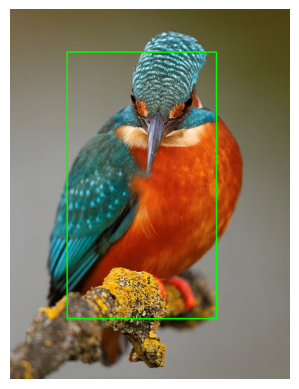

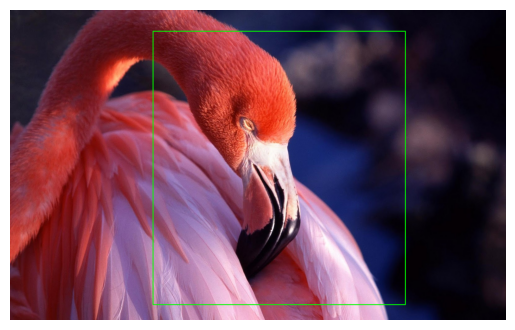

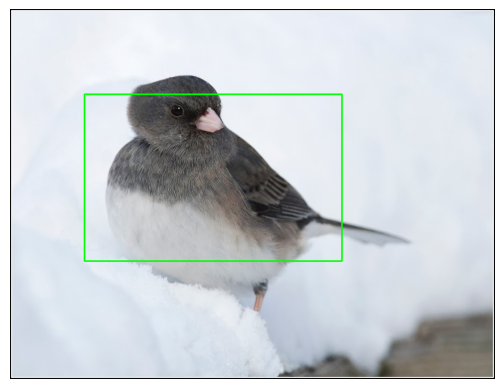

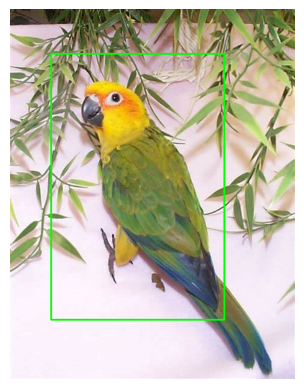

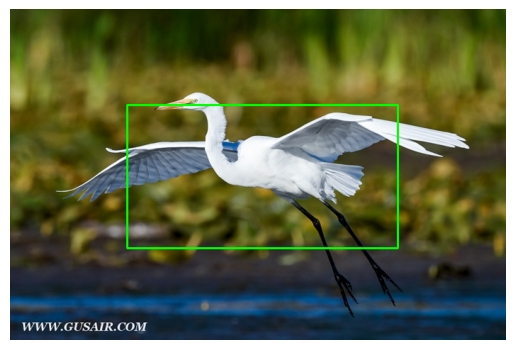

In [11]:
ts_df = pd.read_csv("/kaggle/input/bd-dataframe/test.csv")

for _ in range(5):
    index = r.randint(0, len(ts_df)-1)
    
    image = cv2.cvtColor(src=cv2.imread(ts_df.iloc[index, 0]), code=cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    model = Model().to(cfg.device)
    box = predict(
        model=model,
        image=image,
        device=cfg.device,
        size=cfg.size,
        path="/kaggle/input/bd-en4-na224-e10/saves/ble_state_fold_3.pt",
    )
    
    cx = int(box[0] * w)
    cy = int(box[1] * h)
    w  = int(box[2] * w)
    h  = int(box[3] * h)   
    
    x_min = cx - w//2
    y_min = cy - h//2    
    x_max = cx + w//2    
    y_max = cy + h//2    
    
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.show()